In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize as scipy

The following method returns an np.array of equally spaced points within a cube centered at (0,0,0) with sidelength 2. These are the sphere center candidates, for which we need to find maximum radii.

In [2]:
# Point Generation
def generateLattice(density, inGeometry):   
    grid = np.zeros((density**3, 3))
    
    t = 0
    for x in np.linspace(-1,1,density):
        for y in np.linspace(-1,1,density):
            for z in np.linspace(-1,1,density):
                if (inGeometry(x,y,z)): 
                    grid[t] = np.array([x,y,z])
                    t += 1
                
    return grid[:t]

# Geometric Abstractions

Here, we define various (theoretical) molecule geometries. In the future, I will update the point generation method to handle xyz files (to determine whether any point falls within the atomic radius of a particular atom). For now, they are geometric abstractions.

In [3]:
# Pore Geometries
def spherical(x,y,z):
    return x**2+y**2+z**2<=1
def cylindrical(x,y,z):
    return x**2+y**2<=1 and -1<=z<=1
def cubical(x,y,z):
    return np.abs(x)<=1 and np.abs(y)<=1 and np.abs(z)<=1

def distanceSq(point1, point2):
    # Returns squared distance between two np.array points
    gaps = point1-point2
    return gaps.dot(gaps)

A gradient descent algorithm is implemented here to find the maximum radius that remains within the bounds of the sphere geometry.

In [4]:
def gradient_descent(initial, grad, maxiter = 40, lr = 0.01):
    for i in range(maxiter):
        initial -= lr*gradi
        
    return initial

Here, I will implement my own nonlinear programming algorithm (gradient descent).

In [5]:
def sphericalGradient(center):    
    return lambda p: distanceSq(center[0:2], p[0:2])
    
def sphericalPSD(density):
    points = generateLattice(density, spherical)  
    sphereHeight = lambda p: (1-p.dot(p))**0.5
    sphGrad = lambda center: (lambda p: np.array([2*(p[0]-center[0]) - 2*(1-center[2]/sphereHeight(p[:2]))*p[0], \
                                                    2*(p[1]-center[1]) - 2*(1-center[2]/sphereHeight(p[:2]))*p[1]]))
    
    for center in points:
        # Find max sphere and the points contained
        max_dist_XY = gradient_descent(center[:2], sphGrad(center))
        #radius = distanceSq(center, max_dist_point)**.5
        return center, max_dist_point

Here, PSDs are calculated for the three geometries mentioned above using scipy's optimization package.

In [6]:
def manualSphericalPSD(density):
    points = generateLattice(density, spherical)  
    max_radii = np.zeros((points.shape[0],1), dtype=float)
    old = points[0][0]
    for center in points:
        # Find max sphere and the points contained
        slope = center[2]/center
        slope[2] *= -1
        lin = scipy.LinearConstraint(slope, 0, 0)
        nonlin = scipy.NonlinearConstraint(lambda p: distanceSq(p, np.zeros(3))-1, 0, 0)
        max_dist_XY = scipy.minimize(lambda p: np.sum(p-center), center, method="trust-constr", constraints=[lin, nonlin])
        max_radius = distanceSq(center, max_dist_XY["x"])**0.5
        
        for i in range(len(points)):
            p = points[i]
            if (distanceSq(p, center)<=max_radius**2):
                max_radii[i] = max(max_radius, max_radii[i])
        
        if (center[0] != old): 
            print("x =", old, "completed!")
            old = center[0]
                
    return points, max_radii
    
def manualCubicalPSD(density): 
    points = generateLattice(density, cubical)  
    max_radii = np.zeros((points.shape[0],1), dtype=float)
    old = points[0][0]
    for center in points:
        # Find max sphere and the points contained       
        max_dist_cub = np.min(1-np.abs(center))
        
        for i in range(len(points)):
            p = points[i]
            if (distanceSq(p, center)<=max_dist_cub**2):
                max_radii[i] = max(max_dist_cub, max_radii[i])
        
        if (center[0] != old): 
            print("x =", old, "completed!")
            old = center[0]
                
    return points, max_radii
    
def manualCylindricalPSD(density): 
    points = generateLattice(density, cylindrical)  
    max_radii = np.zeros((points.shape[0],1), dtype=float)
    old = points[0][0]
    for center in points:
        # Find max sphere and the points contained
        vert_rad = 1-np.abs(center[2])
        nonlin = scipy.NonlinearConstraint(lambda p: p[:2].dot(p[:2]), 1, 1)
        max_surface_point = scipy.minimize(lambda p: distanceSq(p, center), center, method="trust-constr", constraints=nonlin)
        
        max_dist_cyl = min(vert_rad, distanceSq(max_surface_point["x"], center) ** 0.5)
        for i in range(len(points)):
            p = points[i]
            if (distanceSq(p, center)<=max_dist_cyl**2):
                max_radii[i] = max(max_dist_cyl, max_radii[i])
        
        if (center[0] != old): 
            print("x =", old, "completed!")
            old = center[0]
                
    return points, max_radii

# Visualizations of Geometric PSD

Either load or generate geometric PSD radii data.

In [7]:
density = 20

In [85]:
points_cub, cub = manualCubicalPSD(density)
#np.save(r"./geometric/points_cub", points_cub)
#np.save(r"./geometric/cub", cub)
points_cyl, cyl = manualCylindricalPSD(density)
#np.save(r"./geometric/points_cyl", points_cyl)
#np.save(r"./geometric/cyl", cyl)
points_sph, sph = manualSphericalPSD(density)
#np.save(r"./geometric/points_sph", points_sph)
#np.save(r"./geometric/sph", sph)

x = -1.0 completed!
x = -0.8947368421052632 completed!
x = -0.7894736842105263 completed!
x = -0.6842105263157895 completed!
x = -0.5789473684210527 completed!
x = -0.4736842105263158 completed!
x = -0.368421052631579 completed!
x = -0.26315789473684215 completed!
x = -0.1578947368421053 completed!
x = -0.052631578947368474 completed!
x = 0.05263157894736836 completed!
x = 0.1578947368421053 completed!
x = 0.26315789473684204 completed!
x = 0.36842105263157876 completed!
x = 0.4736842105263157 completed!
x = 0.5789473684210527 completed!
x = 0.6842105263157894 completed!
x = 0.7894736842105261 completed!
x = 0.894736842105263 completed!


In [8]:
cub=np.load("./geometric/cub.npy")
points_cub=np.load("./geometric/points_cub.npy")
cyl=np.load("./geometric/cyl.npy")
points_cyl=np.load("./geometric/points_cyl.npy")
sph=np.load("./geometric/sph.npy")
points_sph=np.load("./geometric/points_sph.npy")

Now we generate histograms of the radius of the maximal sphere at each point.

In [10]:
def hist_psd(radii, buckets, title = "", file_name=""):
    hist = plt.hist(radii, bins=np.linspace(0,1,buckets))
    plt.title(title)
    if (file_name): plt.savefig(file_name)
    plt.show()
    return hist

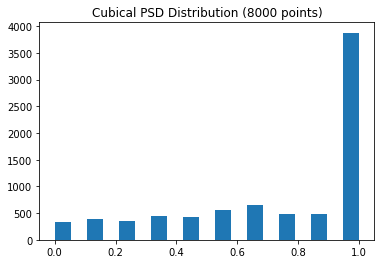

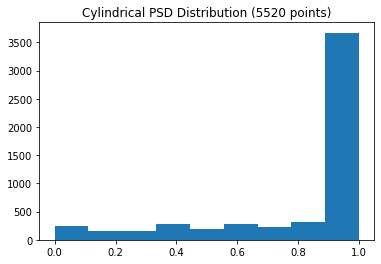

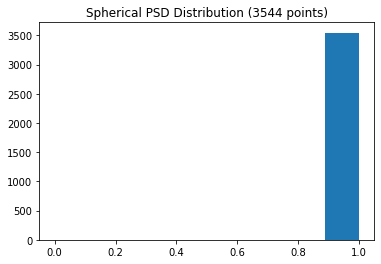

In [11]:
hist_cub = hist_psd(cub, 20, "Cubical PSD Distribution (%d points)"%cub.shape[0], r"./geometric/hist_cub.png")
hist_cyl = hist_psd(cyl, 10, "Cylindrical PSD Distribution (%d points)"%cyl.shape[0], r"./geometric/hist_cyl.png")
hist_sph = hist_psd(sph/2, 10, "Spherical PSD Distribution (%d points)"%sph.shape[0], r"./geometric/hist_sph.png")

In [118]:
# A metric of circularity. 
    # The closer the circularity is to 1, the closer the pore shape is to an unoccluded sphere.
def circularity(radii):
    return np.sum(radii == np.max(radii))/radii.shape[0]

print(circularity(sph), circularity(cyl), circularity(cub))

1.0 0.636231884057971 0.383875


Finally, we generate heatmaps to visualize the radii of maximal spheres at each height (value of z).

In [12]:
def zSlices(density, points, radii):
    zMaps = []
    axis = np.linspace(-1,1,density)
    for z in range(density):
        zPoints = np.zeros((density, density))
        for x in range(density):
            for y in range(density):
                ind = npIndex(points, np.array([axis[x],axis[y],axis[z]]))
                zPoints[x][y] = radii[ind] if (ind > -1) else 0
        #print(axis[z], "finished!")
        zMaps.append(zPoints)
    return zMaps

def npIndex(main, target):
    for i, x in enumerate(main):
        if (np.array_equal(x, target)):
            return i
    return -1

In [121]:
heatmap_sph = zSlices(density, points_sph, sph)
heatmap_cyl = zSlices(density, points_cyl, cyl)
heatmap_cub = zSlices(density, points_cub, cub)

-1.0 finished!
-0.8947368421052632 finished!
-0.7894736842105263 finished!
-0.6842105263157895 finished!
-0.5789473684210527 finished!
-0.4736842105263158 finished!
-0.368421052631579 finished!
-0.26315789473684215 finished!
-0.1578947368421053 finished!
-0.052631578947368474 finished!
0.05263157894736836 finished!
0.1578947368421053 finished!
0.26315789473684204 finished!
0.36842105263157876 finished!
0.4736842105263157 finished!
0.5789473684210527 finished!
0.6842105263157894 finished!
0.7894736842105261 finished!
0.894736842105263 finished!
1.0 finished!
-1.0 finished!
-0.8947368421052632 finished!
-0.7894736842105263 finished!
-0.6842105263157895 finished!
-0.5789473684210527 finished!
-0.4736842105263158 finished!
-0.368421052631579 finished!
-0.26315789473684215 finished!
-0.1578947368421053 finished!
-0.052631578947368474 finished!
0.05263157894736836 finished!
0.1578947368421053 finished!
0.26315789473684204 finished!
0.36842105263157876 finished!
0.4736842105263157 finished!
0

In [13]:
heatmap_sph = np.load("./geometric/heatmap_sph.npy")
heatmap_cyl = np.load("./geometric/heatmap_cyl.npy")
heatmap_cub = np.load("./geometric/heatmap_cub.npy")

In [122]:
#np.save(r"./geometric/heatmap_sph", heatmap_sph)
#np.save(r"./geometric/heatmap_cyl", heatmap_cyl)
#np.save(r"./geometric/heatmap_cub", heatmap_cub)

In [33]:
def psd_heatmaps(heatmap_data, density, name = ""):
    i = 0
    for z in np.linspace(-1,1,density):
        plt.figure(i)
        plt.title("z=" + str(z))
        plt.xlabel("Index of X-Coordinate")
        plt.ylabel("Index of Y-Coordinate")
        plt.imshow(heatmap_data[i])
        if (name): plt.savefig(r"./geometric/%s/%d.png"%(name, i))
        i+=1

# Loading in Stored Data

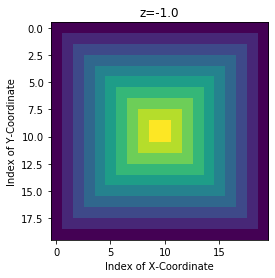

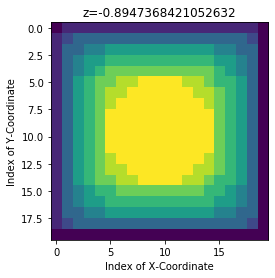

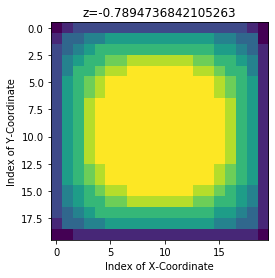

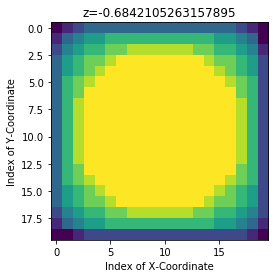

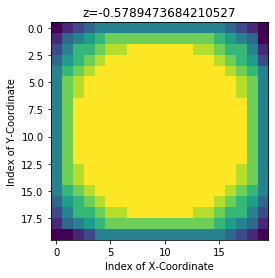

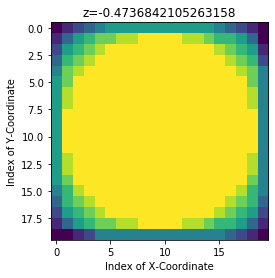

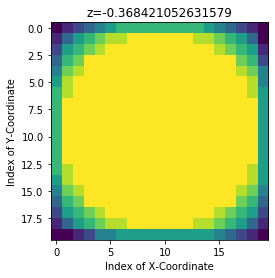

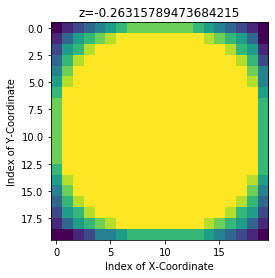

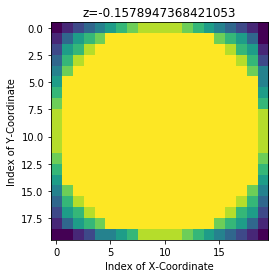

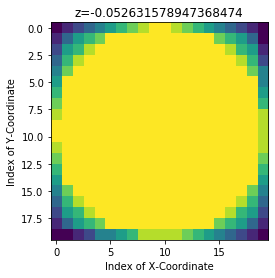

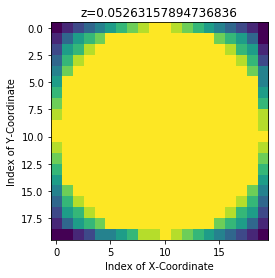

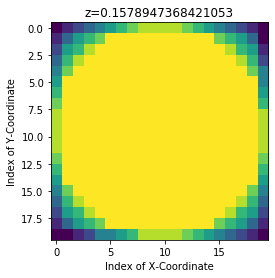

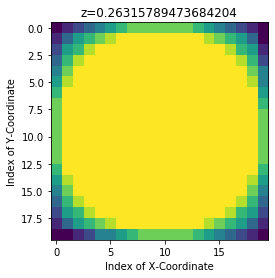

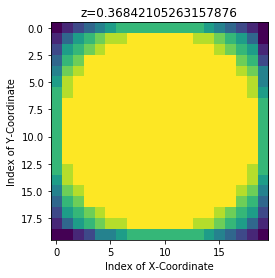

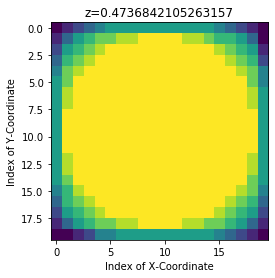

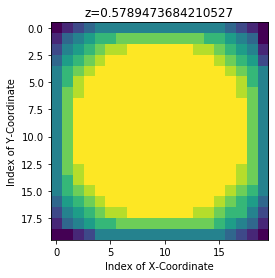

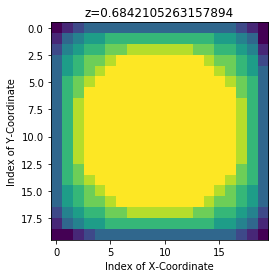

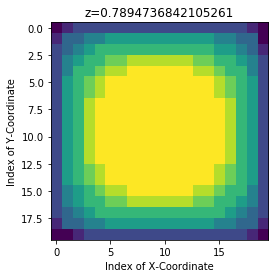

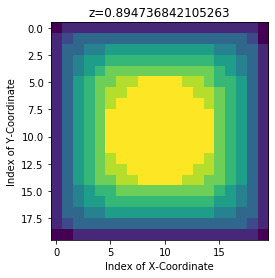

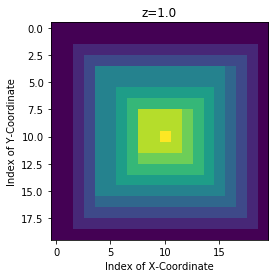

In [34]:
psd_heatmaps(heatmap_sph, density, "sphere_heatmaps")
psd_heatmaps(heatmap_cyl, density, "cylindrical_heatmaps")
psd_heatmaps(heatmap_cub, density, "cubical_heatmaps")

# Real Chemical Structures

In [ ]:
def process_xyz(file_name):
    # Input: an xyz file of N atoms
    # Output: an Nx4 np.array of center(x,y,z) coordinates and atom radius
    with open(file_name) as file:
        atoms = np.array((file.readline(), 4))
        file.readline()
        while(x = file.readline())
            
    return 0

These methods are responsible for the calculation of the pore sizes themselves. The maxporesize method needs to be refined and generalized to process xyz files.

In [ ]:
def maxPoreSize(center, geometry):
    return 

def poreSizeCalculation(poreLocations):
    poreSizes = np.zeros((poreLocations.shape[0]))
    t = 0
    for coord in poreLocations:
        poreSizes[t]=maxPoreSize(coord)
        t+=1
    return poreSizes

These methods calculate various distributions of pore size diameter. CDF is a cumulative distribution which evaluates the probability that a pore is larger than a certain diameter. PDF breaks up the possible diameters into equal ranges and plots each of their frequencies.

In [ ]:
def CDF(poreSizes, interval, normalize=True):
    distribution = np.zeros((interval,2))
    t=0
    for thresh in np.linspace(0,2,interval):
        subPoreSizes = poreSizes[poreSizes>=thresh]
        distribution[t]=thresh, subPoreSizes.shape[0]
        t+=1
    
    if (normalize):
        distribution[:,1] /= poreSizes.shape[0]
            
    return distribution

def PDF(poreSizes, interval, normalize=True):
    distribution = np.zeros((interval-1,2))
    
    t=0
    buckets = np.linspace(0,2,interval)
    for i in range(len(buckets)-1):       
        subPoreSizes = poreSizes[np.logical_and(poreSizes>buckets[i], poreSizes<=buckets[i+1])]
        #subPoreSizes = subPoreSizes[subPoreSizes<=buckets[i+1]]
        distribution[t]=buckets[i], subPoreSizes.shape[0]
        t+=1
    
    if (normalize):
        distribution[:,1] /= poreSizes.shape[0]
    
    return distribution

A plotting function is included here, for reference.

In [ ]:
def psdPlot(distribution, density, geometry=(lambda x,y,z: True), interval=100, pointGeneration=generateLattice):
    grid = pointGeneration(density, geometry)
    poreSizes = poreSizeCalculation(grid)
    distro = distribution(poreSizes, interval)
    
    plt.xlabel("Maximal Diameter")
    plt.ylabel("Probability Distribution")
    plt.plot(distro[:,0],distro[:,1])
    return distro

In [ ]:
dist = psdPlot(CDF, 50, geometry=spherical, interval=30)